<hr/>

# Data Mining [EN.550.436]
**Tamás Budavári** - budavari@jhu.edu <br/>
**Class 18** - November 2, 2016

- $k$-means clustering
- Gaussian mixtures
- EM algorithm

<hr/>

<h1><font color="darkblue">Clustering</font></h1>

## Statistical Learning

- The methods in general fall in these 4 categories

>|                | Supervised     |         Unsupervised     |
 |:---------------|:--------------:|:------------------------:|
 | **Discrete**   | Classification | Clustering               |   
 | **Continuous** | Regression     | Dimensionality Reduction |



## Clustering is ...

... the process of collecting a set of objects into groups or clusters of similar items

####For example,

- Discover different species of birds based on their photographs
- Segment an image based on the pixel colors
- Organize news articles that cover the same story

<img src=http://www.codeproject.com/KB/recipes/439890/clustering-process.png width=450 align=left>

## $k$-means clustering

A simple (flat) algorithm


### Optimization

- Formally, it's an optimization over the possible groupings of objects

> For a set of $\{ x_l \}$ where $x_l\in \mathbb{R}^d$ for all $l$

>$\displaystyle  \hat{\boldsymbol{C}} = \textrm{arg}\min_{\boldsymbol{C}} \sum_{i=1}^k \left[\ \sum_{x\in{}C_i}\ |\!|x-\mu_i|\!|^2 \right] $

> where 

>$\displaystyle  \mu_i = \frac{1}{|C_i|}\sum_{x\in{}C_i} x $

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


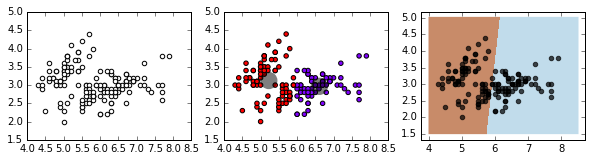

In [2]:
from sklearn import datasets
from sklearn.cluster import KMeans

iris = datasets.load_iris()
X = iris.data[:,:2] # 0,1列

figure(figsize=(10,4)); #总图
ax=subplot(131,aspect='equal')#子图1
scatter(X[:,0],X[:,1],c='w');#画散点

kmeans = KMeans(n_clusters=2)#初始化
kmeans.fit(X)
C, L = kmeans.cluster_centers_, kmeans.labels_

ax=subplot(132,aspect='equal')#子图2
scatter(X[:,0],X[:,1],c=L,cmap=cm.rainbow);#按标签给颜色,颜色总范围是彩虹
scatter(C[:,0],C[:,1],c='k',marker='o',s=300,alpha=0.5,edgecolor='none');#中心点

if True:
    h = .005 # point in the mesh [x_min, m_max]x[y_min, y_max].
    # Plot the decision boundary. For that, we will assign a color to each,画出的图有颜色区域
    x_min, x_max = 4, 8.5
    y_min, y_max = 1.5, 5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    P = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    P = P.reshape(xx.shape)

    # Put the result into a color plot
    ax=subplot(133,aspect='equal')
    plt.imshow(P, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='equal', origin='lower', alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c='k', alpha=0.7)

## Limitations

- Initialization matters

> Rerun multiple times: **n_init** (default=10) <br/>
> Smart(er) starting points

- Assumes spherical clusters (use of distance function)

> Preprocessing becomes important even in simple cases <br>
> For example, whitening...

## So This Won't Work!

<img src=http://www.squobble.com/academic/ftvmimo/spiral_A.png width=250 align=left>

## What $k$?

- How many clusters?

> Too many? <br/>
> Too few?

- Various diagnostics

> Check the minimum value of the cost function? <br/>
> Characterize the clusters - Gaussian? spherical?



## Example

- Run $k$-means on this [CSV](files/Class18-Clusters.csv) file
- Try different parameters
- How many clusters did you find?

In [3]:
# Okay, you didn't see this because this generates the data
from scipy.stats import norm
np.random.seed(seed=1)
x1 = norm.rvs(0, 0.99, size=(3, 66)); x1[0,:] += 2.1
x2 = norm.rvs(0, 0.99, size=(3, 67)); x2[1,:] += 2.1
x3 = norm.rvs(0, 0.99, size=(3, 67)); x3[2,:] += 6
x = hstack((x1,x2,x3)); 
savetxt("files/Class18-Clusters.csv", x.T, delimiter=",")

(200L, 3L)


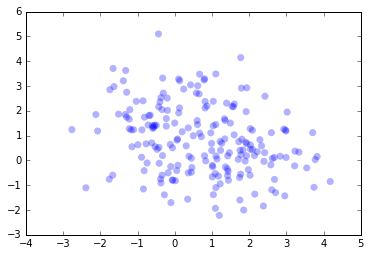

In [4]:
X = loadtxt('files/Class18-Clusters.csv', delimiter=',')
print X.shape
scatter(X[:,0],X[:,1],s=50,alpha=0.3,edgecolor='none');

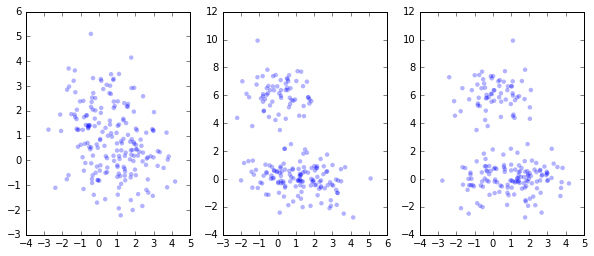

In [5]:
X = loadtxt('files/Class18-Clusters.csv', delimiter=',')

figure(figsize=(10,4))#总图
for i,m,n in [(1,0,1),(2,1,2),(3,0,2)]:#for 循环画子图,三个维度,两两画出来
    ax=subplot(1,3,i)#定位子图i
    scatter(X[:,m],X[:,n],alpha=0.3, edgecolor='none');#画子图i

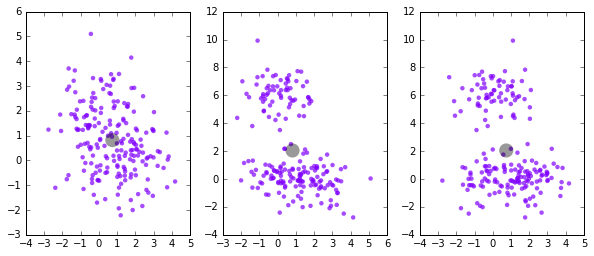

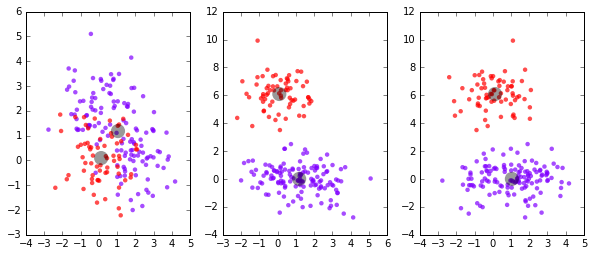

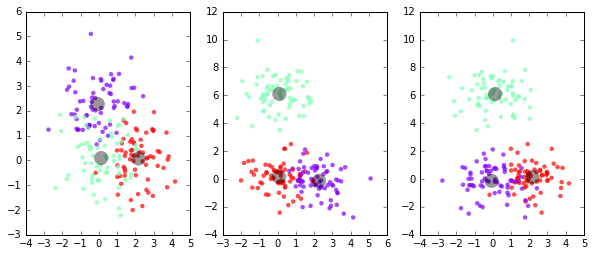

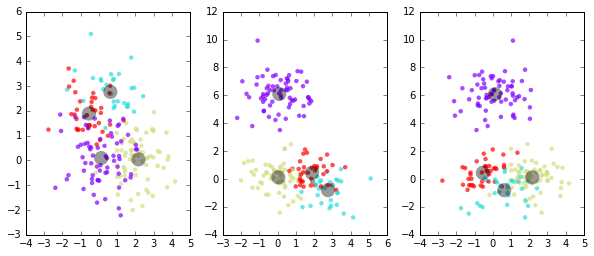

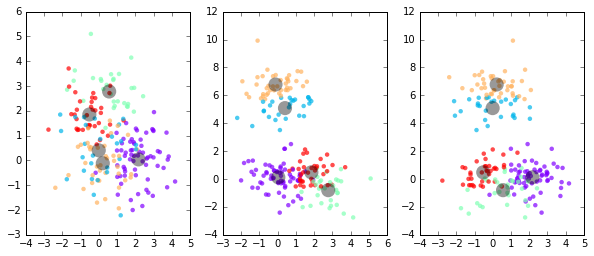

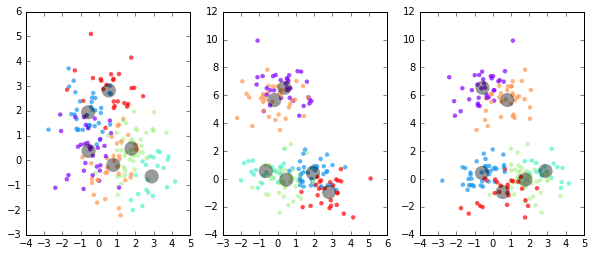

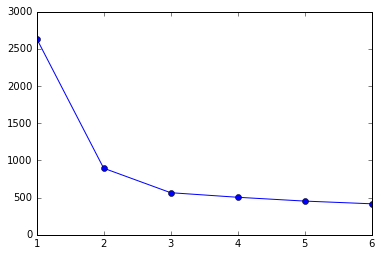

In [6]:
klist = []
ilist = []
for k in range(1,7):
    kmeans = KMeans(n_clusters=k, copy_x=False,n_init=20)
    kmeans.fit(X)
    klist.append(k)
    ilist.append(kmeans.inertia_)
    if True:
        C, L = kmeans.cluster_centers_, kmeans.labels_
        figure(figsize=(10,4))
        for i,m,n in [(1,0,1),(2,1,2),(3,0,2)]:
            ax=subplot(1,3,i) #,aspect='equal')
            scatter(X[:,m],X[:,n],c=L,cmap=cm.rainbow, alpha=0.7, edgecolor='none');
            scatter(C[:,m],C[:,n],c='k',marker='o',s=200,alpha=0.4,edgecolor='none');
figure(); plot(klist,ilist,'o-');#k增大,总距离减小

## Gaussian Mixture Models

- A probabilistic approach to clustering

> Infer the parameters of $k$ **components**

- For example, a mixture of two Gaussians ($k\!=\!2$)

> **Parameters** $\boldsymbol{\theta}$ are $(\mu_1,\Sigma_1),\ (\mu_2,\Sigma_2)$ and the<br>
> cluster membership probabilities $\boldsymbol{\kappa}$ 


## GMM with $k=2$


- Difficult because of the unknown cluster memberships $\boldsymbol{\kappa}$

> $\kappa_i$ is the probability of that $x_i$ belongs to component 1 <br>
> $(1\!-\!\kappa_i)$ is the prob of belonging to component 2

- Likelihood function

>$\displaystyle L(\boldsymbol{\theta};\boldsymbol{x}) = \prod_{i=1}^n \Big[ \kappa_i\, G\left(x_i;\mu_1,\Sigma_1\right) + (1\!-\!\kappa_i)\, G\left(x_i; \mu_2,\Sigma_2\right)\Big]$

## Expectation-Maximization Algorithm

- The EM algorithm is a general framework

>0. Create an initial model $\theta$
>0. Find a better $\theta'$ s.t. <br> 
> the likelihood improves: $p(D|\theta') > p(D|\theta)$ <br/> 
> (or the posterior)
>0. Repeat until convergence


## Step-by-step
<img src=http://orig02.deviantart.net/e551/f/2012/098/9/a/3_easy_steps_to_draw_mona_lisa____by_mcdaotri21-d4vhuu2.png align=left width=450>

## E-step

- Calculate the membership probabilities $\boldsymbol{\kappa}$

> Based on the current model $(\mu_1,\mu_2,\Sigma_1,\Sigma_2)$ and data $\boldsymbol{x}$

## M-step

- Maximize the likelihood function 

> Based on the estimated membership probabilities

- In spirit, this is not completely unlike $k$-means clustering algorithm

## Visual Example

<!--
<img src=https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif align=left>
-->

<img src=https://upload.wikimedia.org/wikipedia/commons/a/a7/Em_old_faithful.gif align=left width=400>

## Iris

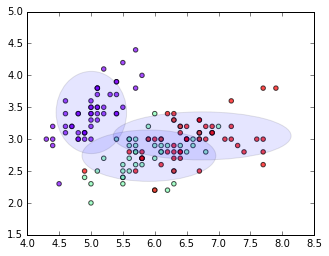

In [11]:
from matplotlib.patches import Ellipse
from sklearn import datasets
from sklearn import mixture#基本都有拓展包...现成的方法

iris = datasets.load_iris()
X = iris.data[:,:]

ax = subplot(111, aspect='equal')
scatter(X[:,0], X[:,1], c=iris.target, cmap=cm.rainbow, alpha=0.7)#只画两个维度

gmm = mixture.GMM(n_components=3)
gmm.fit(X)
for n in arange(3): # covariance ellipses, see sklearn doc
    v, w = np.linalg.eigh(gmm._get_covars()[n][:2,:2])
    angle = 180/pi * arctan2(w[0,1], w[0,0])
    v *= 9
    ell = Ellipse(gmm.means_[n,:2], v[0],v[1], 180+angle)
    ell.set_alpha(0.1)
    ax.add_artist(ell)

## What Gaussian?

<!--<img src=http://scikit-learn.org/stable/_images/plot_gmm_classifier_0011.png align=left width=400>-->

<img src=files/plot_gmm_classifier_0011.png align=left width=400>

## Comparison

- Gaussion Mixture Model

> Find components with matching distribution

- $k$-means clustering

> Tends to yield spherical clusters with similar sizes

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/675px-ClusterAnalysis_Mouse.svg.png" width=600 align=left>

### Soft Clustering?

- GMM provides quality to each possible cluster membership

> Instead of just in/out, have the likelihoods for all


### More Clustering

- Read and learn about the following algorithms:

> Agglomerative clustering

> DBSCAN

- Overview of clustering on sklearn

> Read more [here](http://scikit-learn.org/stable/modules/clustering.html)

### Next Spectral Clustering

- Read and learn about the following algorithms:

> Agglomerative clustering

> DBSCAN

- Overview of clustering on sklearn

> Read more [here](http://scikit-learn.org/stable/modules/clustering.html)